## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder


In [90]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [92]:
import pandas as pd

# 데이터 로드
train = pd.read_csv('../data/train.csv').drop(columns=['ID'])
test = pd.read_csv('../data/test.csv').drop(columns=['ID'])

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형', '특정_시술_유형',
       '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부', '난자

In [93]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_시기_코드               256351 non-null  object 
 1   시술_당시_나이               256351 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 3   시술_유형                  256351 non-null  object 
 4   특정_시술_유형               256349 non-null  object 
 5   배란_자극_여부               256351 non-null  int64  
 6   배란_유도_유형               256351 non-null  object 
 7   단일_배아_이식_여부            250060 non-null  float64
 8   착상_전_유전_검사_사용_여부       2718 non-null    float64
 9   착상_전_유전_진단_사용_여부       250060 non-null  float64
 10  남성_주_불임_원인             256351 non-null  int64  
 11  남성_부_불임_원인             256351 non-null  int64  
 12  여성_주_불임_원인             256351 non-null  int64  
 13  여성_부_불임_원인             256351 non-null  int64  
 14  부부_주_불임_원인             256351 non-nu

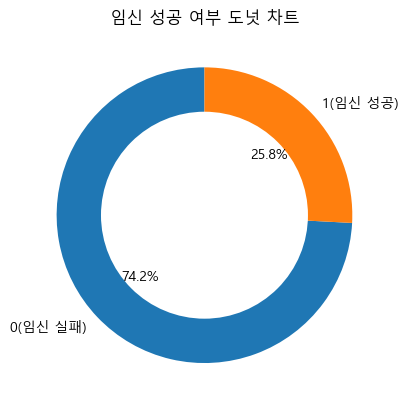

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [95]:
# '난자_출처' 변수의 값이 '알수없음'에 해당 안하는 데이터 추출
known_train = train[train['난자_출처'] != '알 수 없음'] # '알 수 없음' 일 경우  시술유형이 DI
known_test = test[test['난자_출처'] != '알 수 없음']

# 새로운 데이터셋 생성
print("난자_출처가 '알수없음'이 아닌 데이터셋:")
print(known_train)

난자_출처가 '알수없음'이 아닌 데이터셋:
       시술_시기_코드 시술_당시_나이  임신_시도_또는_마지막_임신_경과_연수 시술_유형 특정_시술_유형  배란_자극_여부  \
0        TRZKPL  만18-34세                    NaN   IVF     ICSI         1   
1        TRYBLT  만45-50세                    NaN   IVF     ICSI         0   
2        TRVNRY  만18-34세                    NaN   IVF      IVF         1   
3        TRJXFG  만35-37세                    NaN   IVF     ICSI         1   
4        TRVNRY  만18-34세                    NaN   IVF     ICSI         1   
...         ...      ...                    ...   ...      ...       ...   
256346   TRYBLT  만18-34세                    NaN   IVF     ICSI         1   
256347   TRYBLT  만38-39세                    NaN   IVF     ICSI         1   
256348   TRVNRY  만35-37세                    NaN   IVF     ICSI         1   
256349   TRZKPL  만38-39세                    NaN   IVF     ICSI         1   
256350   TRXQMD  만35-37세                    NaN   IVF      IVF         0   

          배란_유도_유형  단일_배아_이식_여부  착상_전_유전_검사_사용_여부  착상_전_유전_진단_사

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_시기_코드               256351 non-null  object 
 1   시술_당시_나이               256351 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 3   시술_유형                  256351 non-null  object 
 4   특정_시술_유형               256349 non-null  object 
 5   배란_자극_여부               256351 non-null  int64  
 6   배란_유도_유형               256351 non-null  object 
 7   단일_배아_이식_여부            250060 non-null  float64
 8   착상_전_유전_검사_사용_여부       2718 non-null    float64
 9   착상_전_유전_진단_사용_여부       250060 non-null  float64
 10  남성_주_불임_원인             256351 non-null  int64  
 11  남성_부_불임_원인             256351 non-null  int64  
 12  여성_주_불임_원인             256351 non-null  int64  
 13  여성_부_불임_원인             256351 non-null  int64  
 14  부부_주_불임_원인             256351 non-nu

In [97]:
known_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250060 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_시기_코드               250060 non-null  object 
 1   시술_당시_나이               250060 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  9067 non-null    float64
 3   시술_유형                  250060 non-null  object 
 4   특정_시술_유형               250058 non-null  object 
 5   배란_자극_여부               250060 non-null  int64  
 6   배란_유도_유형               250060 non-null  object 
 7   단일_배아_이식_여부            250060 non-null  float64
 8   착상_전_유전_검사_사용_여부       2718 non-null    float64
 9   착상_전_유전_진단_사용_여부       250060 non-null  float64
 10  남성_주_불임_원인             250060 non-null  int64  
 11  남성_부_불임_원인             250060 non-null  int64  
 12  여성_주_불임_원인             250060 non-null  int64  
 13  여성_부_불임_원인             250060 non-null  int64  
 14  부부_주_불임_원인             250060 non-nu

In [98]:
known_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87891 entries, 0 to 90066
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   시술_시기_코드               87891 non-null  object 
 1   시술_당시_나이               87891 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  3209 non-null   float64
 3   시술_유형                  87891 non-null  object 
 4   특정_시술_유형               87891 non-null  object 
 5   배란_자극_여부               87891 non-null  int64  
 6   배란_유도_유형               87891 non-null  object 
 7   단일_배아_이식_여부            87891 non-null  float64
 8   착상_전_유전_검사_사용_여부       933 non-null    float64
 9   착상_전_유전_진단_사용_여부       87891 non-null  float64
 10  남성_주_불임_원인             87891 non-null  int64  
 11  남성_부_불임_원인             87891 non-null  int64  
 12  여성_주_불임_원인             87891 non-null  int64  
 13  여성_부_불임_원인             87891 non-null  int64  
 14  부부_주_불임_원인             87891 non-null  int64  
 15  부부

In [99]:
# '난자_출처' 변수의 값이 '알수없음'이 아닌 해당하는 데이터 추출
known_train = train[(train['난자_출처'] != '알 수 없음') & (train['시술_당시_나이'] != '알 수 없음')]
known_test = test[(test['난자_출처'] != '알 수 없음') & (test['시술_당시_나이'] != '알 수 없음')]

# 모든 값이 결측값인 변수를 제거
known_train = known_train.dropna(axis=1, how='all')
known_test = known_test.dropna(axis=1, how='all')

# # 고유값의 종류가 하나인 변수를 제거
# for column in known_train.columns:
#     if known_train[column].nunique() == 1:
#         known_train = known_train.drop(columns=[column])
#         known_test = known_test.drop(columns=[column])

# 결과 출력
print("모든 행의 값이 결측값인 변수를 제거하고, 고유값의 종류가 하나인 변수를 제거한 데이터셋:")
print(known_train.info())

# 데이터셋을 CSV 파일로 저장 (UTF-8 인코딩 설정)
known_train.to_csv('known_train.csv', index=False, encoding='utf-8-sig')

print("데이터셋이 'known_train.csv' 파일로 저장되었습니다.")

모든 행의 값이 결측값인 변수를 제거하고, 고유값의 종류가 하나인 변수를 제거한 데이터셋:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 249731 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_시기_코드               249731 non-null  object 
 1   시술_당시_나이               249731 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  9067 non-null    float64
 3   시술_유형                  249731 non-null  object 
 4   특정_시술_유형               249729 non-null  object 
 5   배란_자극_여부               249731 non-null  int64  
 6   배란_유도_유형               249731 non-null  object 
 7   단일_배아_이식_여부            249731 non-null  float64
 8   착상_전_유전_검사_사용_여부       2718 non-null    float64
 9   착상_전_유전_진단_사용_여부       249731 non-null  float64
 10  남성_주_불임_원인             249731 non-null  int64  
 11  남성_부_불임_원인             249731 non-null  int64  
 12  여성_주_불임_원인             249731 non-null  int64  
 13  여성_부_불임_원인             249731 non-null

In [100]:
train = known_train
test = known_test

In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249731 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_시기_코드               249731 non-null  object 
 1   시술_당시_나이               249731 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  9067 non-null    float64
 3   시술_유형                  249731 non-null  object 
 4   특정_시술_유형               249729 non-null  object 
 5   배란_자극_여부               249731 non-null  int64  
 6   배란_유도_유형               249731 non-null  object 
 7   단일_배아_이식_여부            249731 non-null  float64
 8   착상_전_유전_검사_사용_여부       2718 non-null    float64
 9   착상_전_유전_진단_사용_여부       249731 non-null  float64
 10  남성_주_불임_원인             249731 non-null  int64  
 11  남성_부_불임_원인             249731 non-null  int64  
 12  여성_주_불임_원인             249731 non-null  int64  
 13  여성_부_불임_원인             249731 non-null  int64  
 14  부부_주_불임_원인             249731 non-nu

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [102]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRCMWS    0.739496  0.260504  27510  9691  37201
TRDQAZ    0.750692  0.249308  28473  9456  37929
TRJXFG    0.729620  0.270380  25633  9499  35132
TRVNRY    0.736164  0.263836  25885  9277  35162
TRXQMD    0.741243  0.258757  25140  8776  33916
TRYBLT    0.727240  0.272760  26033  9764  35797
TRZKPL    0.741169  0.258831  25640  8954  34594


## 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [103]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
만18-34세   0.674737  0.325263  67747  32658  100405
만35-37세   0.718321  0.281679  40463  15867   56330
만38-39세   0.779704  0.220296  29780   8414   38194
만40-42세   0.838043  0.161957  30431   5881   36312
만43-44세   0.878486  0.121514  10396   1438   11834
만45-50세   0.825871  0.174129   5497   1159    6656


## 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [104]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1    0    1  Total
variable                                     
0.0       0.666667  0.333333    8    4     12
1.0       0.500000  0.500000    2    2      4
2.0       0.809524  0.190476   17    4     21
3.0       0.762500  0.237500   61   19     80
4.0       0.759322  0.240678  224   71    295
5.0       0.753687  0.246313  511  167    678
6.0       0.747126  0.252874  715  242    957
7.0       0.765453  0.234547  904  277   1181
8.0       0.782379  0.217621  888  247   1135
9.0       0.790744  0.209256  786  208    994
10.0      0.778384  0.221616  713  203    916
11.0      0.808036  0.191964  543  129    672
12.0      0.776639  0.223361  379  109    488
13.0      0.835853  0.164147  387   76    463
14.0      0.775701  0.224299  249   72    321
15.0      0.791165  0.208835  197   52    249
16.0      0.845771  0.154229  170   31    201
17.0      0.820896  0.179104  110   24    134
18.0      0.836538  0.163462   87   17

In [105]:
# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

# 결측값을 known으로 채우기
train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

결측값 개수: 240664
결측값 개수: 0


In [106]:
test['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum()

0

In [107]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.666667  0.333333       8      4      12
1.0       0.500000  0.500000       2      2       4
2.0       0.809524  0.190476      17      4      21
3.0       0.762500  0.237500      61     19      80
4.0       0.759322  0.240678     224     71     295
5.0       0.753687  0.246313     511    167     678
6.0       0.747126  0.252874     715    242     957
7.0       0.765453  0.234547     904    277    1181
8.0       0.782379  0.217621     888    247    1135
9.0       0.790744  0.209256     786    208     994
10.0      0.778384  0.221616     713    203     916
11.0      0.808036  0.191964     543    129     672
12.0      0.776639  0.223361     379    109     488
13.0      0.835853  0.164147     387     76     463
14.0      0.775701  0.224299     249     72     321
15.0      0.791165  0.208835     197     52     249
16.0      0.845771  0.

## 4. 시술_유형

IVF 또는 DI 시술 여부

In [108]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                0        1       0      1   Total
variable                                         
IVF       0.73805  0.26195  184314  65417  249731


In [109]:
test['시술_유형'].value_counts()

IVF    87775
Name: 시술_유형, dtype: int64

IVF 와 DI 시술중 IVF 시술 데이터만 제공됨

In [110]:
# '시술_유형' 변수 제거
train = train.drop(columns=['시술_유형'])
test = test.drop(columns=['시술_유형'])

In [111]:
len(train['임신_성공_여부'])

249731

## 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [112]:
len(train['특정_시술_유형'])

249731

시술유형에 대해서 특정 시술 유형값이 존재하는거!

In [113]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                                  group  '임신_성공_여부' count     ratio   Total
0                                   FER                 1  0.333333       3
1                                  GIFT                 0  0.000000       1
2                                  ICSI             33385  0.272849  122357
3                             ICSI / AH               167  0.217165     769
4                     ICSI / AH:Unknown                 1  0.500000       2
5                    ICSI / BLASTOCYST                574  0.356743    1609
6               ICSI / BLASTOCYST :ICSI                 1  1.000000       1
7   ICSI / BLASTOCYST :IVF / BLASTOCYST                 1  0.250000       4
8    ICSI / BLASTOCYST:IVF / BLASTOCYST                 2  0.333333       6
9                             ICSI:ICSI                23  0.009965    2308
10                             ICSI:IVF               205  0.234822     873
11                         ICSI:Unknown                21  0.10144

In [114]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [115]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [116]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1      0      1   Total
variable                                                   
ICSI               0.732522  0.267478  92111  33634  125745
ICSI / AH          0.782101  0.217899    603    168     771
ICSI / BLASTOCYST  0.643210  0.356790   1042    578    1620
IVF                0.740766  0.259234  68952  24130   93082
IVF / AH           0.816199  0.183801    262     59     321
IVF / BLASTOCYST   0.633814  0.366186    791    457    1248
Unknown            0.762789  0.237211  20548   6390   26938


In [117]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1      0      1   Total
variable                                                   
ICSI               0.732522  0.267478  92111  33634  125745
ICSI / AH          0.782101  0.217899    603    168     771
ICSI / BLASTOCYST  0.643210  0.356790   1042    578    1620
IVF                0.740766  0.259234  68952  24130   93082
IVF / AH           0.816199  0.183801    262     59     321
IVF / BLASTOCYST   0.633814  0.366186    791    457    1248
Unknown            0.762789  0.237211  20548   6390   26938


In [118]:
test['변환된_특정_시술_유형'].value_counts()

ICSI                 44391
IVF                  32827
Unknown               9213
ICSI / BLASTOCYST      586
IVF / BLASTOCYST       389
ICSI / AH              264
IVF / AH               105
Name: 변환된_특정_시술_유형, dtype: int64

In [119]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

## 10. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [120]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.736864  0.263136  178839  63864  242703
1         0.779043  0.220957    5472   1552    7024


## 11. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [121]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737238  0.262762  181721  64768  246489
1         0.799876  0.200124    2590    648    3238


## 12. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [122]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.736813  0.263187  178498  63759  242257
1         0.778179  0.221821    5813   1657    7470


## 13. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [123]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737256  0.262744  181859  64811  246670
1         0.802094  0.197906    2452    605    3057


## 14. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [124]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.736695  0.263305  177998  63619  241617
1         0.778422  0.221578    6313   1797    8110


## 15. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [125]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737402  0.262598  182541  65005  247546
1         0.811554  0.188446    1770    411    2181


## 16. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [126]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737623  0.262377  137147  48784  185931
1         0.739294  0.260706   47164  16632   63796


## 17. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [127]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737420  0.262580  157990  56257  214247
1         0.741855  0.258145   26321   9159   35480


## 18. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [128]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.750845  0.249155  117990  39153  157143
1         0.716333  0.283667   66321  26263   92584


## 19. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [129]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.742089  0.257911  160798  55885  216683
1         0.711566  0.288434   23513   9531   33044


## 22. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [130]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737616  0.262384  170823  60765  231588
1         0.743591  0.256409   13488   4651   18139


## 23. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [131]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738046  0.261954  184135  65355  249490
1         0.742616  0.257384     176     61     237


## 26. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [132]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                0        1       0      1   Total
variable                                         
0         0.73803  0.26197  184202  65384  249586
1         0.77305  0.22695     109     32     141


## 28. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [133]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0회        0.707814  0.292186  68728  28371  97099
1회        0.747959  0.252041  41787  14081  55868
2회        0.752227  0.247773  28708   9456  38164
3회        0.758188  0.241812  17778   5670  23448
4회        0.766479  0.233521  10884   3316  14200
5회        0.776087  0.223913   6478   1869   8347
6회 이상     0.789461  0.210539   9948   2653  12601


In [134]:
test['총_시술_횟수'].value_counts()

0회       34207
1회       19644
2회       13325
3회        8246
4회        4965
6회 이상     4370
5회        3018
Name: 총_시술_횟수, dtype: int64

## 29. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [135]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0회        0.715490  0.284510  86326  34327  120653
1회        0.752076  0.247924  44013  14509   58522
2회        0.757755  0.242245  25259   8075   33334
3회        0.761231  0.238769  13234   4151   17385
4회        0.769582  0.230418   7074   2118    9192
5회        0.781922  0.218078   3711   1035    4746
6회 이상     0.796268  0.203732   4694   1201    5895


## 30. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [136]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0회        0.707931  0.292069  70854  29232  100086
1회        0.747206  0.252794  42853  14498   57351
2회        0.751908  0.248092  28959   9555   38514
3회        0.761942  0.238058  17386   5432   22818
4회        0.769657  0.230343  10288   3079   13367
5회        0.783773  0.216227   5970   1647    7617
6회 이상     0.802186  0.197814   8001   1973    9974


## 31. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [137]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0회        0.738232  0.261768  177914  63086  241000
1회        0.760754  0.239246    1291    406    1697
2회        0.735436  0.264564    1376    495    1871
3회        0.711382  0.288618    1575    639    2214
4회        0.724036  0.275964     732    279    1011
5회        0.739617  0.260383     463    163     626
6회 이상     0.733945  0.266055     960    348    1308


## 32. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [138]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0회        0.739148  0.260852  148826  52522  201348
1회        0.732256  0.267744   30508  11155   41663
2회        0.739652  0.260348    4378   1541    5919
3회        0.748571  0.251429     524    176     700
4회        0.770115  0.229885      67     20      87
5회        0.857143  0.142857       6      1       7
6회 이상     0.666667  0.333333       2      1       3


## 33. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [139]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.739062  0.260938  149360.0  52734.0  202094
1회        0.732116  0.267884   30109.0  11017.0   41126
2회        0.742922  0.257078    4277.0   1480.0    5757
3회        0.751891  0.248109     497.0    164.0     661
4회        0.765432  0.234568      62.0     19.0      81
5회        0.857143  0.142857       6.0      1.0       7
6회 이상     0.000000  1.000000       0.0      1.0       1


## 34. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [140]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.738164  0.261836  183690.0  65157.0  248847
1회        0.711111  0.288889     544.0    221.0     765
2회        0.653465  0.346535      66.0     35.0     101
3회        0.727273  0.272727       8.0      3.0      11
4회        1.000000  0.000000       1.0      0.0       1
5회        1.000000  0.000000       2.0      0.0       2


## 35. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [141]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.739598  0.260402  158197.0  55699.0  213896
1회        0.728675  0.271325   24466.0   9110.0   33576
2회        0.732186  0.267814    1531.0    560.0    2091
3회        0.702703  0.297297     104.0     44.0     148
4회        0.769231  0.230769      10.0      3.0      13
5회        1.000000  0.000000       1.0      0.0       1
6회 이상     1.000000  0.000000       2.0      0.0       2


## 36. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [142]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.739500  0.260500  158608.0  55872.0  214480
1회        0.728834  0.271166   24112.0   8971.0   33083
2회        0.737208  0.262792    1484.0    529.0    2013
3회        0.700730  0.299270      96.0     41.0     137
4회        0.769231  0.230769      10.0      3.0      13
5회        1.000000  0.000000       1.0      0.0       1


## 37. DI_출산_횟수

DI 시술로 출산한 횟수

In [143]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.738154  0.261846  183869.0  65224.0  249093
1회        0.699313  0.300687     407.0    175.0     582
2회        0.666667  0.333333      32.0     16.0      48
3회        0.500000  0.500000       1.0      1.0       2
5회        1.000000  0.000000       2.0      0.0       2


## 55. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [144]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
만20세 이하   0.761842  0.238158     579    181     760
만21-25세   0.727231  0.272769    3202   1201    4403
만26-30세   0.714654  0.285346    2770   1106    3876
만31-35세   0.716777  0.283223    2713   1072    3785
만36-40세   0.716793  0.283207    2941   1162    4103
만41-45세   0.723245  0.276755    2122    812    2934
알 수 없음    0.739492  0.260508  169984  59882  229866


## 56. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [145]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.731817  0.268183  153391  56212  209603
1.0       0.770611  0.229389   30920   9204   40124


## 57. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [146]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.770427  0.229573   30757   9165   39922
1.0       0.731889  0.268111  153554  56251  209805


## 58. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [147]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.738702  0.261298  182658  64611  247269
1.0       0.672498  0.327502    1653    805    2458


## 59. 대리모_여부

환자가 대리모로 활동했는지 여부

In [148]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.738169  0.261831  183570  65113  248683
1.0       0.709770  0.290230     741    303    1044


## 60. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [149]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.720514  0.279486  1570  609   2179


In [150]:
train['PGD_시술_여부'].isnull().sum()

247548

In [151]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna('0', inplace=True)
test['PGD_시술_여부'].fillna('0', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 247548
결측값 개수: 0


## 61. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [152]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.793675  0.206325  1531  398   1929


In [153]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna('0', inplace=True)
test['PGS_시술_여부'].fillna('0', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 247798
결측값 개수: 0


## 62. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [154]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.735747  0.264253  146070  52463  198533


In [155]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['난자_채취_경과일'])
test = test.drop(columns=['난자_채취_경과일'])

## 63. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [156]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                0        1       0      1  Total
variable                                        
0.0       0.77739  0.22261  1114.0  319.0   1433
1.0       1.00000  0.00000     2.0    0.0      2


In [157]:
train['난자_해동_경과일'].isnull().sum()

248292

## 64. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [158]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.722882  0.277118  145942.0  55947.0  201889
1.0       0.846311  0.153689     413.0     75.0     488
2.0       0.754902  0.245098      77.0     25.0     102
3.0       0.720588  0.279412      49.0     19.0      68
4.0       0.600000  0.400000       3.0      2.0       5
5.0       0.791667  0.208333      19.0      5.0      24
6.0       1.000000  0.000000       8.0      0.0       8
7.0       1.000000  0.000000       1.0      0.0       1


In [159]:
train['난자_혼합_경과일'].isnull().sum()

47142

In [160]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna('unknown', inplace=True)
test['난자_혼합_경과일'].fillna('unknown', inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 47142
결측값 개수: 0


In [161]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.722882  0.277118  145942.0  55947.0  201889
1.0       0.846311  0.153689     413.0     75.0     488
2.0       0.754902  0.245098      77.0     25.0     102
3.0       0.720588  0.279412      49.0     19.0      68
4.0       0.600000  0.400000       3.0      2.0       5
5.0       0.791667  0.208333      19.0      5.0      24
6.0       1.000000  0.000000       8.0      0.0       8
7.0       1.000000  0.000000       1.0      0.0       1
unknown   0.801812  0.198188   37799.0   9343.0   47142


## 65. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [162]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0.0       0.748986  0.251014  18652   6251  24903
1.0       0.812985  0.187015   4921   1132   6053
2.0       0.787531  0.212469  27625   7453  35078
3.0       0.741230  0.258770  42935  14989  57924
4.0       0.655639  0.344361   2953   1551   4504
5.0       0.595546  0.404454  48512  32946  81458
6.0       0.699964  0.300036   1941    832   2773
7.0       0.588889  0.411111     53     37     90


In [163]:
train['배아_이식_경과일'].isnull().sum()

36944

In [164]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna('unknown', inplace=True)
test['배아_이식_경과일'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 36944
결측값 개수: 0


In [165]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0.0       0.748986  0.251014  18652   6251  24903
1.0       0.812985  0.187015   4921   1132   6053
2.0       0.787531  0.212469  27625   7453  35078
3.0       0.741230  0.258770  42935  14989  57924
4.0       0.655639  0.344361   2953   1551   4504
5.0       0.595546  0.404454  48512  32946  81458
6.0       0.699964  0.300036   1941    832   2773
7.0       0.588889  0.411111     53     37     90
unknown   0.993910  0.006090  36719    225  36944


## 66. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [166]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.770346  0.229654  30659.0  9140.0  39799
1.0       0.837838  0.162162     31.0     6.0     37
2.0       0.840659  0.159341    153.0    29.0    182
3.0       0.890244  0.109756    146.0    18.0    164
4.0       1.000000  0.000000     12.0     0.0     12
5.0       0.785714  0.214286    110.0    30.0    140
6.0       0.833333  0.166667     25.0     5.0     30
7.0       1.000000  0.000000      3.0     0.0      3


In [167]:
test['배아_해동_경과일'].value_counts()

0.0    13748
3.0       59
2.0       57
5.0       55
1.0       17
6.0        7
4.0        4
Name: 배아_해동_경과일, dtype: int64

In [168]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna('unknown', inplace=True)
test['배아_해동_경과일'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 209360
결측값 개수: 0


In [169]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.770346  0.229654   30659.0   9140.0   39799
1.0       0.837838  0.162162      31.0      6.0      37
2.0       0.840659  0.159341     153.0     29.0     182
3.0       0.890244  0.109756     146.0     18.0     164
4.0       1.000000  0.000000      12.0      0.0      12
5.0       0.785714  0.214286     110.0     30.0     140
6.0       0.833333  0.166667      25.0      5.0      30
7.0       1.000000  0.000000       3.0      0.0       3
unknown   0.731620  0.268380  153172.0  56188.0  209360


## 67. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [170]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1         0        1   Total
variable                                     
0         1.0  0.0  184311.0      0.0  184311
1         0.0  1.0       0.0  65416.0   65416


In [171]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249727 entries, 0 to 256350
Data columns (total 66 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_시기_코드               249727 non-null  object 
 1   시술_당시_나이               249727 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  249727 non-null  object 
 3   배란_자극_여부               249727 non-null  int64  
 4   배란_유도_유형               249727 non-null  object 
 5   단일_배아_이식_여부            249727 non-null  float64
 6   착상_전_유전_검사_사용_여부       2718 non-null    float64
 7   착상_전_유전_진단_사용_여부       249727 non-null  float64
 8   남성_주_불임_원인             249727 non-null  int64  
 9   남성_부_불임_원인             249727 non-null  int64  
 10  여성_주_불임_원인             249727 non-null  int64  
 11  여성_부_불임_원인             249727 non-null  int64  
 12  부부_주_불임_원인             249727 non-null  int64  
 13  부부_부_불임_원인             249727 non-null  int64  
 14  불명확_불임_원인              249727 non-nu

In [172]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87775 entries, 0 to 90066
Data columns (total 65 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   시술_시기_코드               87775 non-null  object 
 1   시술_당시_나이               87775 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  87775 non-null  object 
 3   배란_자극_여부               87775 non-null  int64  
 4   배란_유도_유형               87775 non-null  object 
 5   단일_배아_이식_여부            87775 non-null  float64
 6   착상_전_유전_검사_사용_여부       932 non-null    float64
 7   착상_전_유전_진단_사용_여부       87775 non-null  float64
 8   남성_주_불임_원인             87775 non-null  int64  
 9   남성_부_불임_원인             87775 non-null  int64  
 10  여성_주_불임_원인             87775 non-null  int64  
 11  여성_부_불임_원인             87775 non-null  int64  
 12  부부_주_불임_원인             87775 non-null  int64  
 13  부부_부_불임_원인             87775 non-null  int64  
 14  불명확_불임_원인              87775 non-null  int64  
 15  불임

In [173]:
X = train.drop('임신_성공_여부', axis=1)
y = train['임신_성공_여부']

### 인코딩 

In [174]:
categorical_columns = [
    "시술_시기_코드", 
    "시술_당시_나이", 
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "배아_생성_주요_이유",
    "총_시술_횟수",
    "클리닉_내_총_시술_횟수",
    "IVF_시술_횟수",
    "DI_시술_횟수",
    "총_임신_횟수",
    "IVF_임신_횟수",
    "DI_임신_횟수",
    "총_출산_횟수",
    "IVF_출산_횟수",
    "DI_출산_횟수",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "PGD_시술_여부",
    "PGS_시술_여부",
    "난자_혼합_경과일",
    "배아_이식_경과일",
    "배아_해동_경과일",
    "변환된_특정_시술_유형"
]

In [175]:
# 모든 범주형 변수를 문자열로 변환
X[categorical_columns] = X[categorical_columns].astype(str)

In [176]:
# OrdinalEncoder를 사용하여 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Optuna

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna 목적 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'num_leaves': trial.suggest_int('num_leaves', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 3, 300),
        'boosting_type': 'gbdt',
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return auc

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=800)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 최적의 하이퍼파라미터로 모델 학습
best_params = trial.params
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)

# 예측
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

{'n_estimators': 681, 'num_leaves': 846, 'max_depth': 10, 'learning_rate': 0.011124128507693187,  
'min_child_samples': 296}. Best is trial 501 with value: 0.7387282113709752.  

## Modeling


--- Model Performance ---
Model Accuracy: 0.7426820966643976
Model F1 Score: 0.2011437095972153
Model AUC: 0.7387282113709752


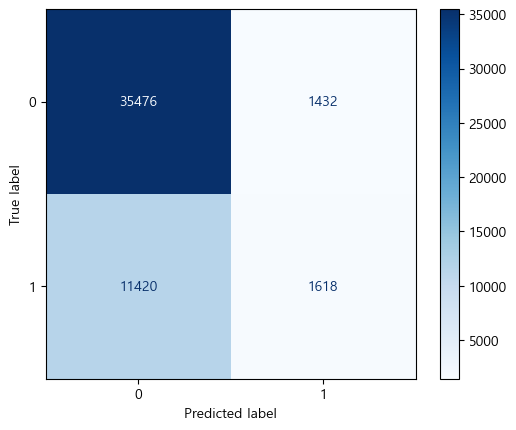

In [178]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
model = lgb.LGBMClassifier(
    n_estimators=681,
    num_leaves=846,
    max_depth=10,
    learning_rate=0.011124128507693187,
    min_child_samples=296,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
    )

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

.